In [2]:
# import necessary modules
import sys
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [05:05<00:00, 32444.24it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 99953.29it/s] 


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 890122.62it/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4497291.97it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
class NeuralNet(nn.Module):
    def __init__(self , input_size , hidden_1 , hidden_2):
        super(NeuralNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size*input_size, hidden_1),
            nn.ReLU(),
            nn.Linear(hidden_1, hidden_2),
            nn.ReLU(),
            nn.Linear(hidden_2, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)

model = NeuralNet(28 , 128 , 64)

In [6]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 5 
training_losses = [] 
accuracies = [] 
def trainer(model,epochs=1,verbose=True): 
    for epoch in range(epochs): 
        running_loss = 0
        for images, labels in trainloader :
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output , labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_training_loss = running_loss / len(trainloader)
        training_losses.append(avg_training_loss)

        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

        print(f"Epoch {epoch+1}: Training Loss: {avg_training_loss:.4f}, Accuracy: {accuracy:.2f}%")
 
trainer(model,epochs=epochs,verbose=True) 

Epoch 1: Training Loss: 0.3353, Accuracy: 93.06%
Epoch 2: Training Loss: 0.1745, Accuracy: 95.36%
Epoch 3: Training Loss: 0.1412, Accuracy: 95.73%
Epoch 4: Training Loss: 0.1271, Accuracy: 96.38%
Epoch 5: Training Loss: 0.1127, Accuracy: 96.67%


In [7]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Evaluate the trained model using the test data without gradient updates.

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')
# Print out the accuracy of the model on the test set.

Accuracy of the network on the 10000 test images: 96.67%


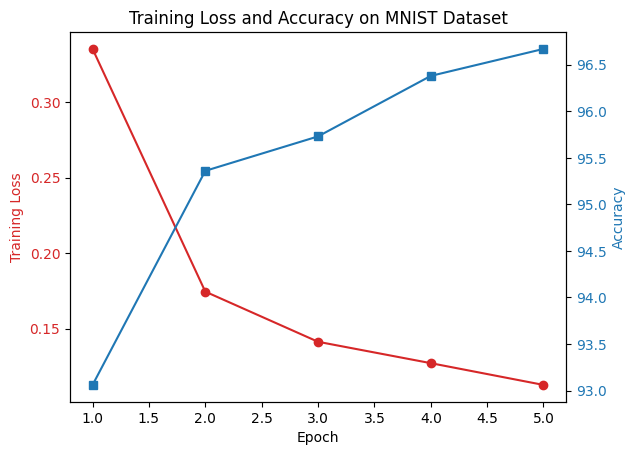

In [8]:
# Creating figure
fig, ax1 = plt.subplots()

# Plotting training loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(np.arange(1, 6), training_losses, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(np.arange(1, 6), accuracies, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Final adjustments
plt.title('Training Loss and Accuracy on MNIST Dataset')
plt.show()

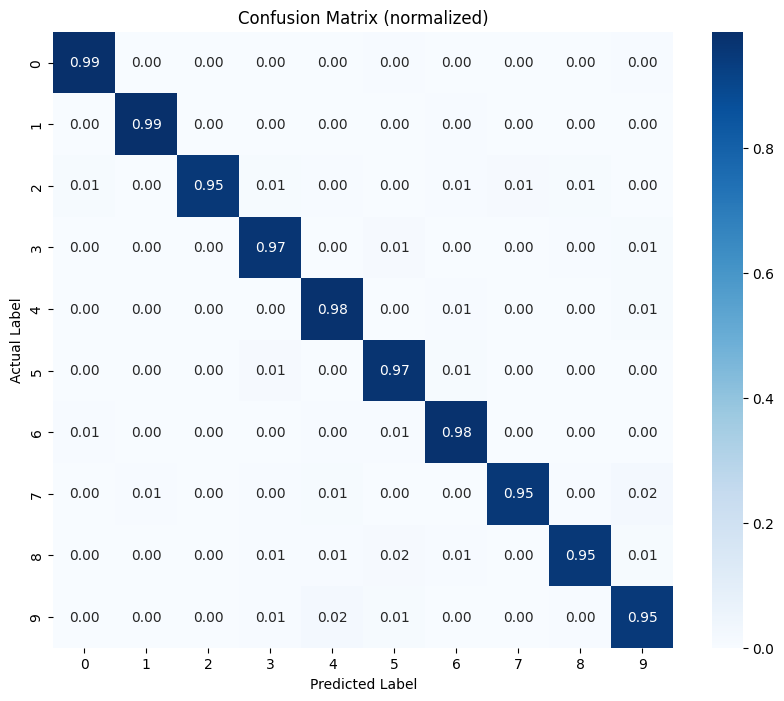

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For visualizing the confusion matrix

# Initial setup
all_predictions = []
all_labels = []

# Model evaluation
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
# Normalize the confusion matrix by row (i.e., by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (normalized)')
plt.show()